# Restauração de Imagens - Filtro de Mínimos Quadrados

## Bibliotecas utilizadas

In [34]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from math import sqrt
from scipy.signal import convolve2d
from skimage import color, data, measure, restoration
import matplotlib.pyplot as plt

## Funções

### Raíz Quadrada do Erro Médio (Root Mean Squared Error - RMSE)

In [35]:
def RMSE(image, corrupted_image):
  errors = []
  N = image.shape[0] * image.shape[1]
  sum = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      error = (int(image[i][j]) - int(corrupted_image[i][j]))**2
      sum += error
      errors.append(error)
  square_root = sqrt(sum)
  rmse = square_root/N
  return rmse

### getMotionDsf()

In [36]:
def getMotionDsf(shape, angle, dist):
  xCenter = (shape[0] - 1) / 2
  yCenter = (shape[1] - 1) / 2
  sinVal = np.sin(angle * np.pi / 180)
  cosVal = np.cos(angle * np.pi / 180)
  PSF = np.zeros(shape)
  for i in range(dist):
    xOffset = round(sinVal * i)
    yOffset = round(cosVal * i)
    PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
  return PSF / PSF.sum()

### makeBlurred()

In [37]:
def makeBlurred(image, PSF, eps):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF) + eps
  fftBlur = np.fft.ifft2(fftImg * fftPSF)
  fftBlur = np.abs(np.fft.fftshift(fftBlur))
  return fftBlur

### getPuv()

In [38]:
def getPuv(image):
  h, w = image.shape[:2]
  hPad, wPad = h - 3, w - 3
  pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
  fftPuv = np.fft.fft2(pxyPad)
  return fftPuv

### leaastSquareFilter()

In [39]:
def leastSquareFilter(image, PSF, eps, gamma=0.01):
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF)
  conj = fftPSF.conj()
  fftPuv = getPuv(image)
  Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
  ifftImg = np.fft.ifft2(fftImg * Huv)
  ifftShift = np.abs(np.fft.fftshift(ifftImg))
  imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))
  return imgLSFilter

### RMSE_evaluation()

In [40]:
def RMSE_evaluation(original_image, restored_images):
  return [RMSE(original_image, restored_image) for restored_image in restored_images]

### resize_img()

In [41]:
def resize_img(img, scale):
  width = int(img.shape[1]*scale/100)
  height = int(img.shape[0]*scale/100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

### generate_interval()

In [42]:
def generate_interval(step, superior_limit, round_precision):
  gamma_values = []
  gamma = 0
  while (True):
    gamma += step
    gamma = round(gamma, round_precision)
    gamma_values.append(gamma)
    if (gamma == superior_limit): break
  return gamma_values

### restore_images()

In [43]:
def restore_images(imgBlurNoisy, PSF, eps, gamma_values):
  restored_images = [leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=gamma) for gamma in gamma_values]
  results = [RMSE(image,restored_image) for restored_image in restored_images]
  index = np.where(results == np.min(results))[0][0]
  print('Menor RMSE:',results[index])
  print('Índice da menor RMSE:', index)
  return restored_images, results, index

## Imagem orignal

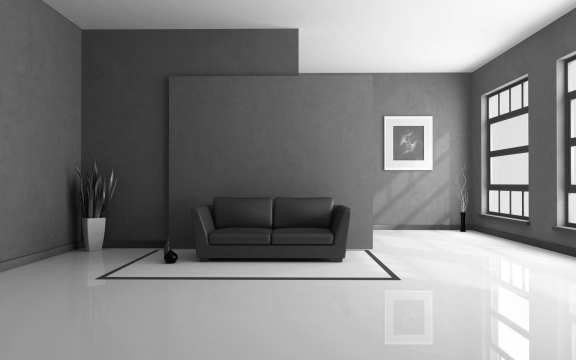

In [44]:
image = resize_img(cv2.imread('rosso', 0), 30)
cv2_imshow(image)

## Degradação da imagem

In [45]:
hImg, wImg = image.shape[:2]
PSF = getMotionDsf((hImg, wImg), 45, 100)

In [46]:
PSF = getMotionDsf((hImg, wImg), 45, 100)
imgBlurred = np.abs(makeBlurred(image, PSF, 1e-6))

scale = 0.01
noisy = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale, size=imgBlurred.shape)
imgBlurNoisy = imgBlurred + noisy

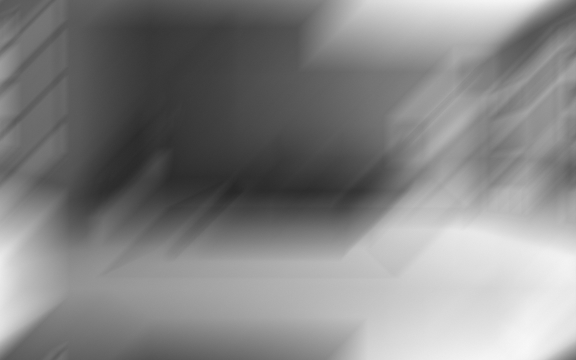

In [47]:
cv2_imshow(imgBlurNoisy)

## Definição do valor ótimo do parâmetro **gamma**

Notamos que a variação do valor do parâmetro **gamma** para o filtro dos Mínimos Quadrados ocasiona borramento na imagem, sendo maior o borramento quanto maior for o valor atribuído ao parâmetro

Algo que foi observado desde a variação dos parâmetros para o filtro bilateral é que o borramento, quando em excesso, sobrepõe todas as demais características da imagem. Em outras palavras: uma vez que aumentamos o nível de borramento da imagem até o ponto em que sua qualidade fica prejudicada, a variação de outros parâmetros, mesmo do ruído, não consegue compensar a degradação gerada pelo borramento excessivo

Essa observação indica que a degradação realizada pelo borramento é uma espécie de parâmetro absoluto, independente de qualquer outro e não afetado pela variação deles. Desta forma, existiria um valor máximo absoluto para o parâmetro **gamma** que pode ser considerado o valor ótimo por suavizar a imagem sem comprometer a nitidez das bordas

Levando isso em conta, podemos aplicar a estratégia de, para um parâmetro qualquer e fixo do coeficiente de ruído (parâmetro **eps**), variar os valores do **gamma** e usar a RMSE para estimar para qual valor a RMSE será minimizada

#### Menor valor do gamma = 0.01; maior valor do gamma = 5


Inicialmente testamos a variação do **gamma** para os valor o valor constante de 0.01 para o **eps**, em um intervalo de 0.01 a 5 (para o qual o borramento é bem acentuado) com saltos de 0.01

In [48]:
gamma_values = generate_interval(0.01, 5, 2)

In [49]:
print(gamma_values)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1

In [50]:
restored_images, results, index = restore_images(imgBlurNoisy, PSF, 0.01, gamma_values)

Menor RMSE: 0.03022257622762577
Índice da menor RMSE: 0


In [51]:
gamma_values[index]

0.01

O melhor valor para o parâmetro **gamma** obtido, de acordo com a aplicação da RMSE, foi de **0.01**. A imagem abaixo mostra a imagem resultante da aplicação desse valor ao parâmetro

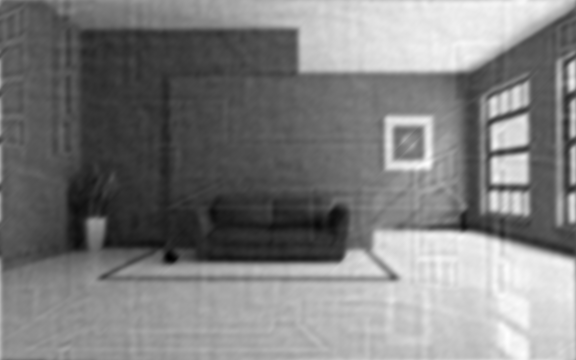

In [52]:
cv2_imshow(leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.01))

É interessante notar que o valor que minimizou a diferença entre a imagem restaurada e a original foi justamente o menor valor dentre todos os coeficientes *gamma* da lista de valores para o coeficinte. Analisando de uma forma superficial a lista dos coeficientes testados - que é mostrada abaixo - podemos ver que os valores parecem descrever um gráfico de uma reta com inclinação positiva, isso é, parece haver uma relação linear crescente entre os resultados da aplicação da RMSE e o coeficiente *gamma*. Os valores da RMSE parecem aumentar à medida em que os coeficientes aumentam, ou seja, quanto maior o coeficiente, mais distante parece ficar a imagem restaurada da imagem original

In [53]:
print(results)

[0.03022257622762577, 0.03255921418237945, 0.03429688949783291, 0.035611150667190096, 0.0367318034754839, 0.03775766316598903, 0.03867971840978043, 0.03955726586841692, 0.04028075883686272, 0.040595014992757666, 0.04086481361455453, 0.04112821307907613, 0.04138225958072316, 0.04161838994746692, 0.041844172140396825, 0.042055016925559394, 0.042255694059444945, 0.042447183035147766, 0.04262724644210546, 0.0428037589603737, 0.0429762929994226, 0.04314638293379698, 0.04330773388815844, 0.04346212506326469, 0.04361721504215234, 0.04377519780329112, 0.04392802968896536, 0.04407584342910086, 0.04421818443298733, 0.044357952158297076, 0.04448979945489061, 0.04461932528296925, 0.04474483071185807, 0.04486941986552613, 0.044991413688758794, 0.04510713712164058, 0.04522114114546593, 0.04533004140925422, 0.045437723805680834, 0.04554172335355259, 0.045643908988662815, 0.045744629178236816, 0.04584391361965303, 0.045939694792461135, 0.046033230849329636, 0.04612489293780279, 0.04621393257040224, 0.

Ao plotar o *scatterplot* relacionando os coeficiente *gamma* com os resultados da RMSE, podemos vizualizar melhor o comportamento da função

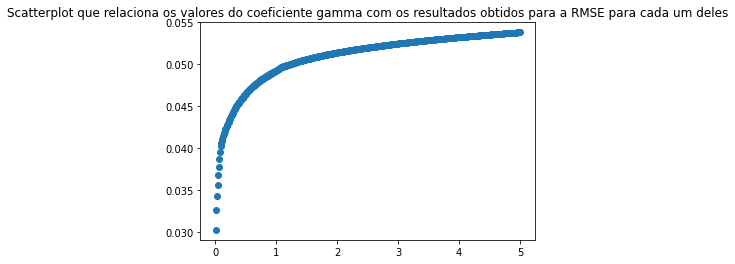

In [54]:
plt.scatter(gamma_values, results,);
plt.title('Scatterplot que relaciona os valores do coeficiente gamma com os resultados obtidos para a RMSE para cada um deles');

O gráfico mostra, no entanto, que a relação entre essas duas variáveis não é linear, mas se assemelha mais a uma relação logarítima, com os valores da RMSE se estabilizando e tendendo a uma assíntota horizontal que tem valor aproximado de 0.055, à medida em que os valores dos coeficientes *gamma* crescem

No que diz respeito a aumentar borramento da imagem esse de fato é o resultado esperado, considerando que uma vez que se atinge o valor ótimo para esse parâmetro, todos os outros valores farão com que a imagem restaurada se distancie da original

## Variação do *gamma* para valores menores

Esse raciocínio também se aplica a um limite inferior do intervalo de valores para no qual o valor ótimo do coeficiente pode ser encontrado: deve haver um valor mínimo para o intervalo de tal forma que, para os valores menores que ele, a imagem restaturada começa a se distanciar cada vez mais da imagem original

Considerando isso e também que o menor dos valores foi aquele considerado o melhor valor para o parâmetro dentre todos os testados, não podemos garantir que o valor encontrado é o melhor em um contexto mais amplo, porque ainda existem valores menores que são convenientes de serem testados e, pelos resultados, não foi encontrado o limite inferior para o qual os valores menores que ele fazem com que a imagem restaurada se distancie da original

Podemos, então, analisar se para um intervalo com menores valores para **gamma** é possível encontrar um melhor resultado do que o que obtivemos

### Definição do limite inferior do intervalo

Sabemos que o limite superior para a análise com menores valores deve ser o 0.01, pois qualquer valor acima dele fará com que a imagem restaurada se distancie cada vez mais da imagem original. Tendo isso em mente, a partir de agora analisaremos a variação dos parâmetros para um intervalo com menores valores, com um limite inferior menor que 0.01, tendo 0.01 como o limite superior do intervalo

Testamos incialmente o valor 0.0001

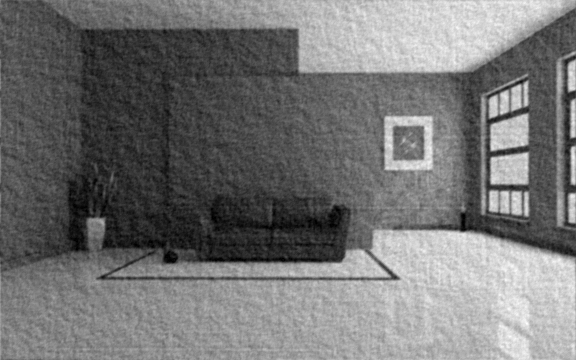

In [55]:
test_0_0001 = leastSquareFilter(imgBlurNoisy, PSF, 0.01, gamma=0.0001)
cv2_imshow(test_0_0001)

In [56]:
RMSE_evaluation(image,[test_0_0001])

[0.046945108201596794]

Considerando que o resultado para o coeficiente 0.0001 foi maior que o para 0.01, ele se trata de um intervalo inferior conveiente, pois indica que o valor ótimo para o **gamma** é maior que ele (e menor que 0.01)


Consideraremos, portanto, um intervalo com valores discretos cujo limite inferior será 0.0001 e o superior será 0.01, com saltos de 0.0001

In [57]:
gamma_values_least = generate_interval(0.0001, 0.01, 4)

In [58]:
print(gamma_values_least)

[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003, 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004, 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048, 0.0049, 0.005, 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056, 0.0057, 0.0058, 0.0059, 0.006, 0.0061, 0.0062, 0.0063, 0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007, 0.0071, 0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008, 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088, 0.0089, 0.009, 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096, 0.0097, 0.0098, 0.0099, 0.01]


In [59]:
restored_images, results, index = restore_images(imgBlurNoisy, PSF, 0.01, gamma_values_least)

Menor RMSE: 0.02771316276239799
Índice da menor RMSE: 15


De fato, para tal intervalo com menores valores de **gamma** consegimos um melhor resultado do que que para o anterior, aproximando ainda mais a imagem restaurada da original

O melhor valor encontrado para o coficiente *gamma* dentre os testados foi **0.0016**

In [60]:
gamma_values_least[index]

0.0016

A imagem mostrada abaixo corresponde à aplicação do filtro de Mínimos Quadrados na imagem degrada para o valor **0.0016**, que, dentre os testados, foi o que apresentou o melhor resultado

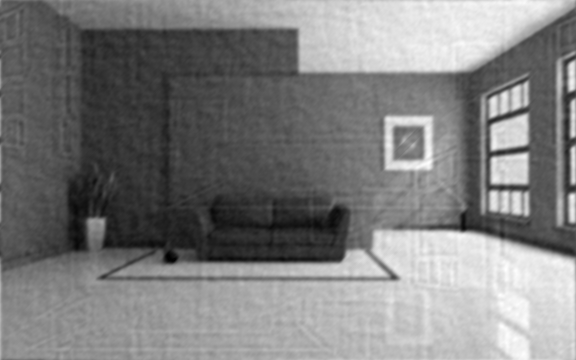

In [61]:
cv2_imshow(restored_images[index])

O gráfico da relação entre as variáveis também apresenta um comportamento semelhante ao da função logarítmica (até o ponto em que fica claro que não existe uma assíntota horizontal para o gráfico)

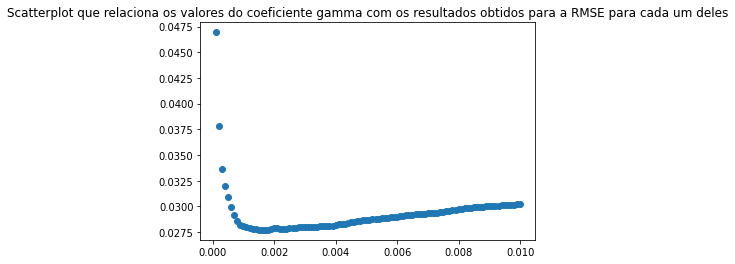

In [62]:
plt.scatter(gamma_values_least, results);
plt.title('Scatterplot que relaciona os valores do coeficiente gamma com os resultados obtidos para a RMSE para cada um deles');

## Avaliação da hipótese da independência do parâmetro **gamma** dos outros parâmetros

Para avaliar se o valor ótimo para o parâmetro **gamma** se mantém o mesmo independente da variação do outro parâmetro (**eps**), obteremos o parâmetro **gamma** ótimo para dois casos: um valor bem evelado de **eps** (que será 5) e outro menor que o testado anteriormente (como testamos 0.01, usaremos 0.001 como o menor valor para o teste dessa vez). Usaremos o mesmo último intervalo de valores *gamma* testado

### Para eps = 5

In [63]:
restored_images, results, index = restore_images(imgBlurNoisy, PSF, 5, gamma_values_least)

Menor RMSE: 0.02771316276239799
Índice da menor RMSE: 15


### Para eps = 0.01

In [64]:
restored_images, results, index = restore_images(imgBlurNoisy, PSF, 0.001, gamma_values_least)

Menor RMSE: 0.02771316276239799
Índice da menor RMSE: 15


Podemos ver que a hipótese que levantamos está correta. Independentemente dos valroes que **eps**, o valor ótimo para a o **gamma** foi o mesmo: **0.016**

In [65]:
gamma_values_least[index]

0.0016

Desta forma, o valor do parâmetro **gamma** tem resultados absolutos, independetes da variação dos outros parâmetros

### Conclusão

Considerando a independência do parâmtro **gamma** dos demais e também que para os valores menores que o limite infeior que definimos agora os resultados da RMSE tendem apenas a aumentar (mostrando que para eles a imagem restaurada fica cada vez mais distante da original) e da mesma forma para os valores acima do limite superior que definimos na análise anterior, podemos conluir que encontramos o valor ótimo para o coeficiente *gamma* com quatro casas decimais de precisão

## Definição do valor ótimo para o **eps**

Para encontrar o valor ótimo do parâmetro **eps** utilizamos a mesma estratégia usada para os valores de **gamma**: definimos um intervalo de valores discretos onde o valor ótimo deve ser encontrado e nesse intervalo, encontramos o valor do **eps** que minimiza a RMSE entre a imagem restaruada e a original. Consideraremos para o valor do **gamma** o valor ótimo encontrado

### Definição dos limites do intervalo

Ao tentar definir os valores do intervalo para o parâmetro **eps**, notamos que ele simplesmente não apresenta nenhuma contribuição na análise da RMSE entre a imagem restaurada e a original, para qualquer valor atribuído a ele. Basicamente, de acordo com a RMSE, a imagem gerada pelo filtro dos Mínimos Quadrados é a mesma para um valor *gamma* constante e qualquer variação do valor do parâmetro **eps**, como se este não tivesse nehuma contribuição na restauração da imagem

#### Imagem restaurada para eps = 0.00001

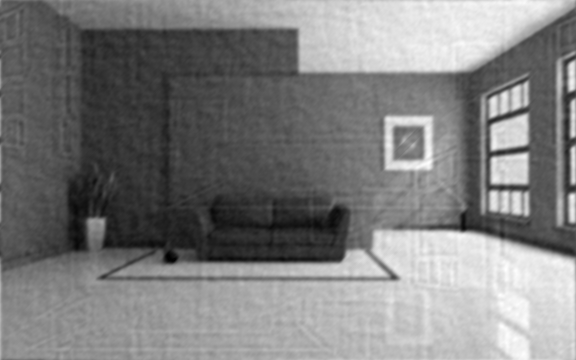

In [101]:
restored_image_1 = leastSquareFilter(imgBlurNoisy, PSF, 0.00001, gamma=0.0016)
cv2_imshow(restored_image_1)

In [102]:
results = RMSE_evaluation(image, [restored_image_1])
results

[0.02771316276239799]

#### Imagem restaurada para esp = 1000

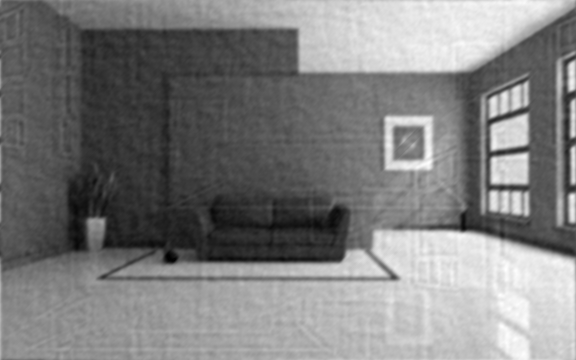

In [103]:
restored_image_2 = leastSquareFilter(imgBlurNoisy, PSF, 1000, gamma=0.0016)
cv2_imshow(restored_image_2)

In [104]:
results = RMSE_evaluation(image, [restored_image_2])
results

[0.02771316276239799]

De fato, ambas as imagens geradas são visualmente idênticas

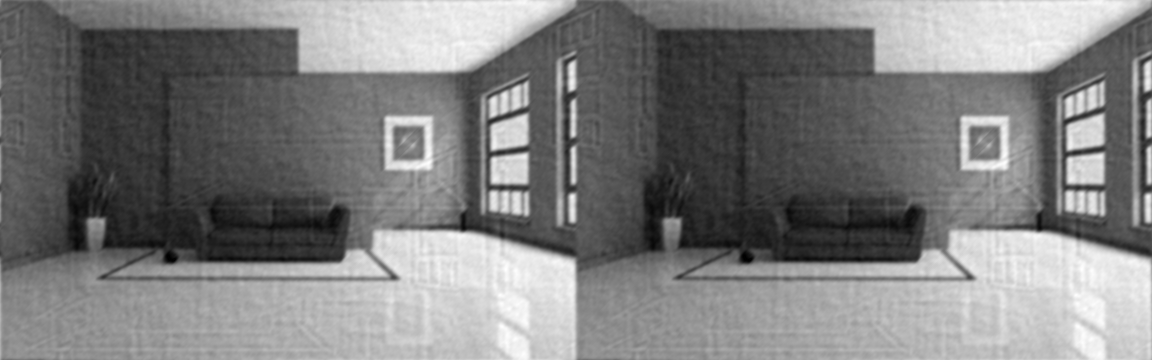

In [107]:
cv2_imshow(np.hstack((restored_image_1, restored_image_2)))

### Conclusão

A variação do parâmetro **eps** parece não gerar qualquer efeito notável sobre o filtro dos Mínimos Quadrados